In [2]:
import librosa
import soundfile as sf
import wave
import os
import glob
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [3]:
origin_fake = './datasets/KAGGLE/AUDIO/FAKE/'
origin_real = './datasets/KAGGLE/AUDIO/REAL/'
new_fake = './datasets/KAGGLE/AUDIO/data_split/FAKE/'
new_real = './datasets/KAGGLE/AUDIO/data_split/REAL/'
data_split_dir = './datasets/KAGGLE/AUDIO/data_split/'
img_spec_real = './datasets/images/spectrogram/REAL/'
img_spec_fake = './datasets/images/spectrogram/FAKE/'
img_mfcc_real = './datasets/images/mfcc/REAL/'
img_mfcc_fake = './datasets/images/mfcc/FAKE/'

clip_len = 10 # 30초 단위로 음원 자르기

### EDA

In [60]:
audio_df = pd.read_csv('feature_extracting.csv')

In [5]:
def showSignalAmplitude(dir) :
    original_wav = wave.open(dir, 'rb')

    sample_freq = original_wav.getframerate()
    n_samples = original_wav.getnframes()
    t_audio = n_samples/sample_freq
    n_channels = original_wav.getnchannels()

    signal_wave = original_wav.readframes(n_samples)
    signal_array = np.frombuffer(signal_wave, dtype=np.int16)

    l_channel = signal_array[0::2]
    r_channel = signal_array[1::2]

    timestamps = np.linspace(0, n_samples/sample_freq, num=n_samples)

    plt.figure(figsize=(7, 2))
    plt.plot(timestamps, l_channel)
    plt.title(os.path.basename(dir))
    plt.ylabel('Signal Value')
    plt.xlabel('Time (s)')
    plt.xlim(0, t_audio)
    plt.show()

- biden : 연설, +배경 소음(환호, 박수)
- linus : 프로덕션 녹음 +배경음악
- musk : 먼 거리에서 녹음
- obama : 연설, +배경 소음(환호, 박수)
- ryan : 인터뷰, +배경 소음(환호, 박수)
- taylor : 인터뷰, +배경 소음(많이 겹치지는 않음)
- trump : 연설, +배경 소음(환호, 박수)

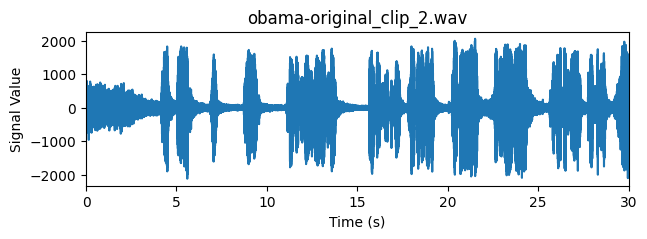

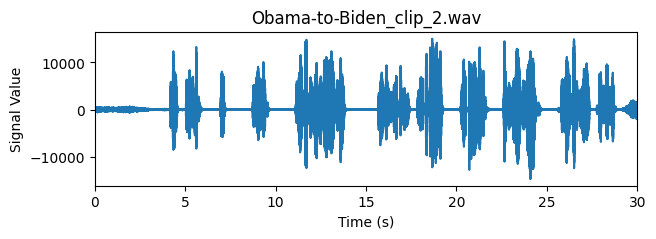

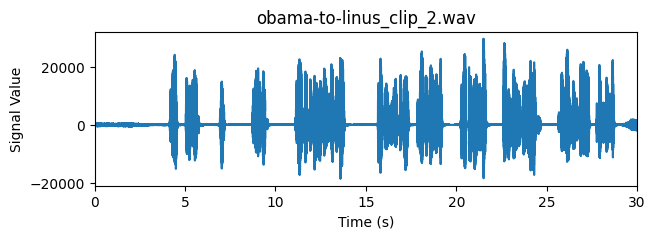

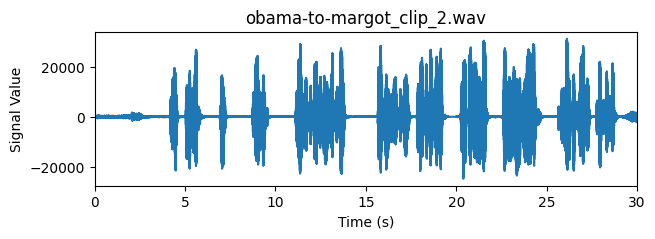

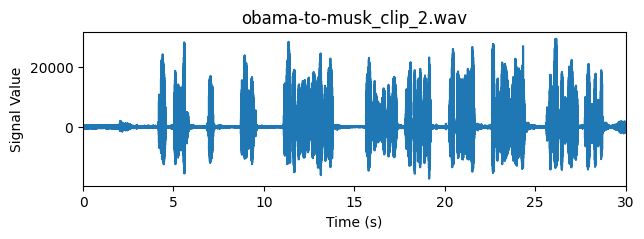

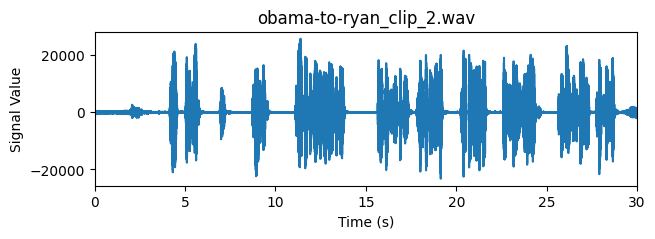

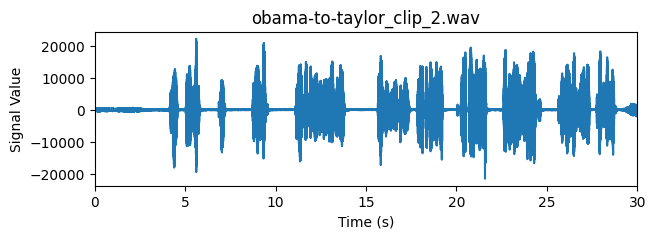

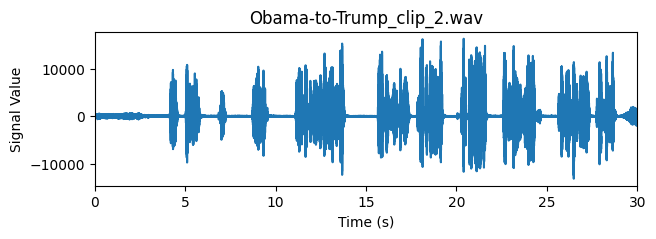

In [191]:
# SignalAmplitude 비교 (음성에 실리는 에너지)
# https://www.yna.co.kr/view/AKR20230611020200064
# 복잡하고(받침이 많고) 긴 딥보이스 문장에서는 발음의 정확도가 떨어져 음성 강도가 낮아지는 특성을 보임
# 전화기 너머로 들리는 진짜 같은 가짜 음성을 쉽게 구분하기는 힘들지만, 평소보다 힘 없이 느껴지거나 일부 단어의 발음이 부정확하다고 판단되면 보이스피싱을 의심해볼 수 있다

for fileName in glob.glob(new_real+'/obama-*clip_2.wav') :
    showSignalAmplitude(fileName)
for fileName in glob.glob(new_fake+'/obama-*clip_2.wav') :
    showSignalAmplitude(fileName)

Text(0.5, 1.0, 'Correlation Heatmap')

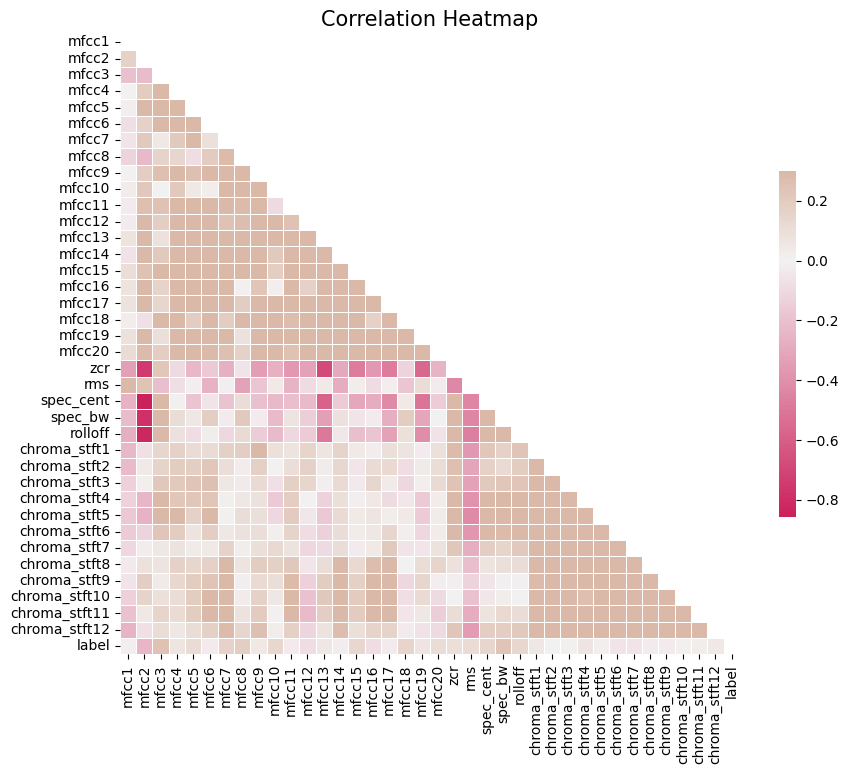

In [82]:
# corr
# mfcc2와 zxr, spec_cent, spec_bw, rolloff의 상관관계가 높음
# rms는 chroma_stft, spec_cent, spec_bw, rolloff와 상관관계가 높음
# label과는 mfcc2, mfcc3, spec_bw가 상관관계가 있으나 크지는 않음, chroma_stft는 상관관계 거의 없음

corr_cols = col_name + ['label']
corr = audio_df[corr_cols].corr()

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 15)


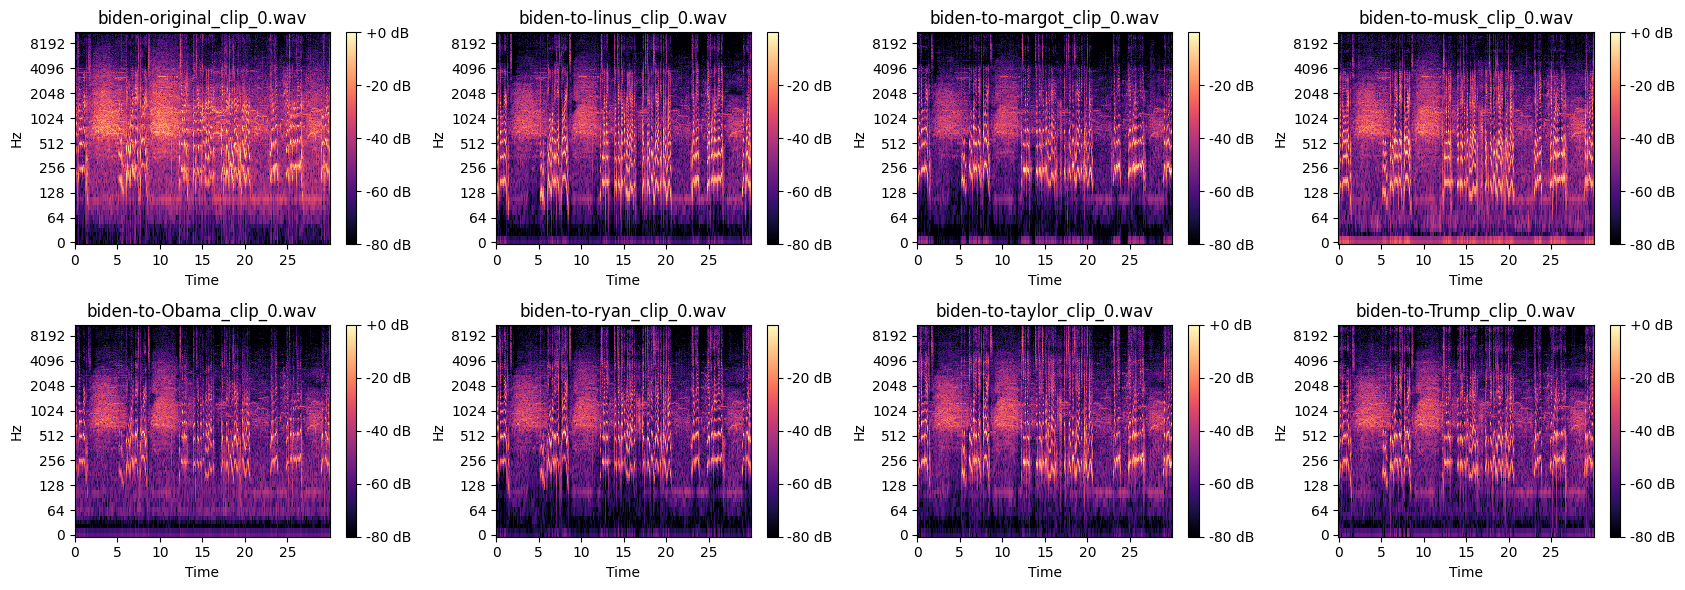

In [171]:
# 연설문 같은 경우 소리가 퍼져있는(전 구간이 밝은 구간) 현상이 발견됨, 목소리의 배음일 수도 있고 배경소음, 에코 때문일 수도 있음
plt.figure(figsize=(17,6))
melspec_idx = 1
for f in glob.glob(data_split_dir+'/**/biden-*clip_0.wav') :
    audio, sample_rate = librosa.load(f)
    spectrogram = np.abs(librosa.stft(audio))
    log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

    folder = os.path.dirname(f)
    fileName = os.path.basename(f)
    
    if folder.endswith('REAL') :
        plt.subplot(2,4,1)
    else :
        plt.subplot(2,4,melspec_idx+1)
        melspec_idx += 1

    librosa.display.specshow(log_spectrogram, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(fileName)

plt.tight_layout()
    
    

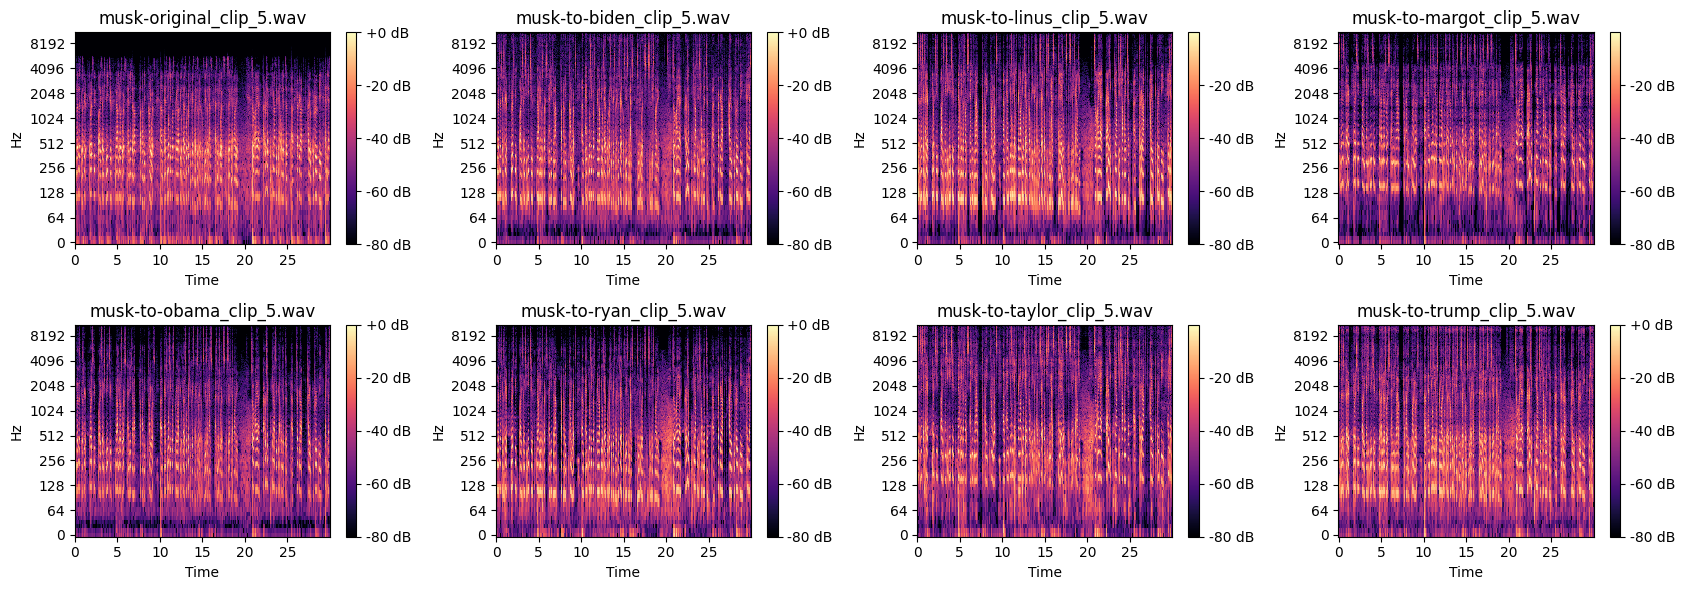

In [169]:
# 멀리에서 잡힌 목소리의 경우 높은 Hz대가 origin은 없고, 합성은 있음
plt.figure(figsize=(17,6))
melspec_idx = 1
for f in glob.glob(data_split_dir+'/**/musk-*clip_5.wav') :
    audio, sample_rate = librosa.load(f)
    spectrogram = np.abs(librosa.stft(audio))
    log_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

    folder = os.path.dirname(f)
    fileName = os.path.basename(f)
    
    if folder.endswith('REAL') :
        plt.subplot(2,4,1)
    else :
        plt.subplot(2,4,melspec_idx+1)
        melspec_idx += 1

    librosa.display.specshow(log_spectrogram, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(fileName)

plt.tight_layout()
    
    

In [208]:
audio_df.loc[audio_df.fileName.str.startswith('linus-original_clip_')].describe()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,chroma_stft4,chroma_stft5,chroma_stft6,chroma_stft7,chroma_stft8,chroma_stft9,chroma_stft10,chroma_stft11,chroma_stft12,label
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,-255.010056,112.694707,-0.859109,22.420927,10.790743,0.443820,-2.683993,1.422355,-2.806427,8.651896,...,0.615282,0.609884,0.602617,0.612813,0.639848,0.665801,0.674771,0.671680,0.637251,0.0
std,12.614242,10.507810,6.535182,3.915969,4.056252,4.462449,3.361105,3.370328,1.512529,1.220985,...,0.036765,0.028134,0.021665,0.026307,0.035305,0.034211,0.023975,0.020169,0.020458,0.0
min,-276.789154,97.659035,-12.203049,12.449482,-0.924658,-8.665133,-8.430299,-6.824175,-6.852386,5.453702,...,0.545386,0.535616,0.549037,0.562427,0.553146,0.571637,0.621554,0.636621,0.591772,0.0
25%,-264.299652,105.647774,-5.367915,21.543919,9.522336,-3.048652,-4.612993,0.704454,-3.037084,8.070333,...,0.598108,0.591224,0.590931,0.590923,0.623014,0.649986,0.663387,0.657402,0.627888,0.0
50%,-254.725601,109.781296,-1.632147,22.928675,11.988338,1.164451,-2.936484,2.201760,-2.306748,8.914225,...,0.626831,0.619689,0.607003,0.614160,0.644198,0.680877,0.682217,0.672703,0.637439,0.0
75%,-242.812622,118.593834,4.647297,24.021476,12.728797,3.984061,-0.806718,3.215010,-1.960213,9.475095,...,0.635199,0.626997,0.617899,0.632808,0.664099,0.687560,0.695102,0.685453,0.644211,0.0
max,-237.922409,134.358917,8.681899,29.139313,16.316820,7.577330,3.654205,6.282207,-1.297669,10.229808,...,0.679976,0.642434,0.636512,0.652199,0.711202,0.707615,0.699046,0.712924,0.689312,0.0


In [212]:
audio_df.loc[audio_df.fileName.str.startswith('linus-to-taylor_clip_')].describe()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,chroma_stft4,chroma_stft5,chroma_stft6,chroma_stft7,chroma_stft8,chroma_stft9,chroma_stft10,chroma_stft11,chroma_stft12,label
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,-267.343325,57.112341,13.868188,32.552920,-1.165117,-2.955206,-6.875203,2.783670,-3.111420,3.847706,...,0.624539,0.620900,0.588807,0.576597,0.594583,0.576914,0.562219,0.562538,0.585761,1.0
std,10.360966,9.768933,5.175680,3.673506,4.493263,3.296881,3.422951,3.386617,3.687670,2.394461,...,0.027430,0.027999,0.026771,0.020260,0.020749,0.019876,0.026319,0.021399,0.024354,0.0
min,-287.611450,34.392281,1.140226,24.307089,-15.073733,-11.461810,-15.626164,-6.246656,-12.522239,-2.293918,...,0.562177,0.571773,0.535566,0.534024,0.569925,0.543816,0.527490,0.505709,0.548990,1.0
25%,-275.761826,53.809259,11.000062,31.014438,-1.213934,-4.021588,-7.756833,2.542685,-3.490642,3.332512,...,0.608901,0.598986,0.575598,0.564900,0.578465,0.564446,0.537716,0.554115,0.569114,1.0
50%,-267.632141,58.215885,14.768126,32.302742,-0.226652,-2.471415,-6.316566,3.755354,-1.955063,4.240026,...,0.624349,0.624315,0.591397,0.580283,0.592348,0.577066,0.565826,0.563654,0.588063,1.0
75%,-259.118423,63.388714,18.099326,34.797346,1.339126,-0.839663,-4.837304,4.626367,-0.855786,5.288115,...,0.641846,0.640268,0.603228,0.587523,0.605797,0.587583,0.581148,0.576691,0.600665,1.0
max,-249.865540,70.696404,19.643936,38.605553,2.886574,1.239589,-0.805074,6.564324,0.216839,6.495769,...,0.671914,0.668704,0.644771,0.610853,0.640028,0.618894,0.620037,0.591714,0.641363,1.0


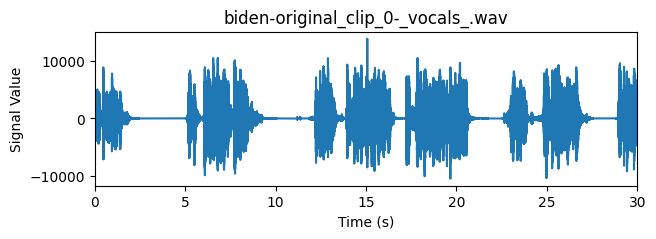

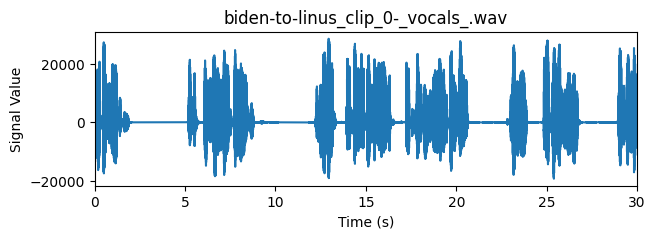

In [8]:
showSignalAmplitude('./datasets/KAGGLE/AUDIO/biden-original_clip_0-_vocals_.wav')
showSignalAmplitude('./datasets/KAGGLE/AUDIO/biden-to-linus_clip_0-_vocals_.wav')